In [5]:
# !git clone https://github.com/openai/guided-diffusion.git

In [6]:
# !pip install -q lovely-tensors lovely-numpy

In [7]:
import sys

sys.path.append("guided-diffusion")

import guided_diffusion  # type: ignore

In [8]:
# !wget -O checkpoint.pt https://openaipublic.blob.core.windows.net/diffusion/jul-2021/128x128_diffusion.pt

In [9]:
from guided_diffusion.script_util import (  # type: ignore
    create_model,
    create_model_and_diffusion,
    model_and_diffusion_defaults,
)

defaults = model_and_diffusion_defaults()

args = {
    "attention_resolutions": "32,16,8",
    "class_cond": True,
    "diffusion_steps": 1000,
    "image_size": 128,
    "learn_sigma": True,
    "noise_schedule": "linear",
    "num_channels": 256,
    "num_heads": 4,
    "num_res_blocks": 2,
    "resblock_updown": True,
    "use_fp16": True,
    "use_scale_shift_norm": True,
}

defaults.update(args)


model, diffusion = create_model_and_diffusion(**defaults)


def beta_to_step(beta):
    betas = 1.0 - diffusion.alphas_cumprod
    index = (betas < beta).astype(float).sum()

    index = int(index)
    if index == len(betas):
        return index - 1
    low_beta = betas[index]
    high_beta = betas[index + 1]

    part = (beta - low_beta) / (high_beta - low_beta)
    step = index + part
    return step

In [10]:
import torch

ckpt = torch.load("checkpoint.pt", map_location="cpu")
model.load_state_dict(ckpt)

model = model.cuda()
model.convert_to_fp16()

model = model.eval()

In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import lovely_tensors as lt


def to_image(x):
    img = x[0].cpu().detach()
    img = (img - img.min()) / (img.max() - img.min())
    img = img.permute(1, 2, 0)
    img = img.numpy()
    img = img * 255.0
    img = img.astype("uint8")
    return img


def call_model(model, x, beta, y=285):
    t = torch.tensor([beta_to_step(beta)]).cuda()
    c = torch.tensor([y]).cuda()

    res = model.forward(x, t, c).detach()

    return res[:, :3, :, :]


def step_to_beta(step):
    index = int(step // 1)
    shift = step % 1

    betas = 1.0 - diffusion.alphas_cumprod

    if index >= len(betas) - 1:
        return betas[-1]

    a = betas[index]
    b = betas[index + 1]

    return a + (b - a) * shift


def beta_to_step(beta):
    betas = 1.0 - diffusion.alphas_cumprod
    index = (betas <= beta).astype(float).sum() - 1

    index = int(index)

    if index < 0:
        return 0

    if index >= len(betas) - 1:
        return len(betas) - 1

    low_beta = betas[index]
    high_beta = betas[index + 1]

    part = (beta - low_beta) / (high_beta - low_beta)
    step = index + part
    return step

In [12]:
generator = torch.Generator().manual_seed(42)

sample = torch.randn([1, 3, 128, 128], generator=generator).cuda()

In [13]:
print(lt.lovely(sample))

tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-4.590, 4.221] μ=0.002 σ=1.007 cuda:0


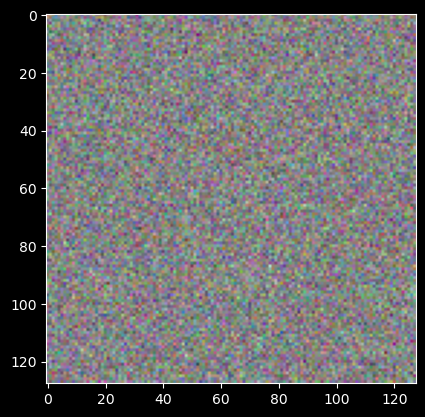

In [14]:
plt.imshow(to_image(sample))

When beta=1.0 the pictures look the same

In [15]:
res = call_model(model, sample, 0.1)

In [16]:
print(lt.lovely(res))

tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-6.549, 6.240] μ=-0.008 σ=1.030 cuda:0


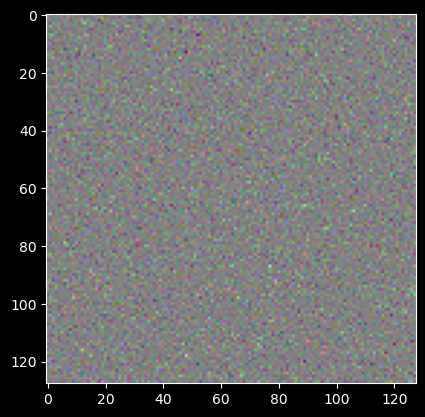

In [17]:
plt.imshow(to_image(res[:, :3]))

# DDIM

In [18]:
generator = torch.Generator().manual_seed(0)

res = torch.randn([1, 3, 128, 128], generator=generator).cuda()

betas = np.linspace(0.001, 0.999, 1000)[::-1]

with torch.no_grad():
    for step in tqdm.trange(len(betas) - 1):

        beta_this = betas[step]
        beta_next = betas[step + 1]

        e = call_model(model, res, beta_this)

        x0 = res - e * np.sqrt(beta_this)
        res = x0 / np.sqrt(1 - beta_this) * np.sqrt(1 - beta_next) + e * np.sqrt(beta_next)

100%|██████████| 999/999 [00:50<00:00, 19.67it/s]


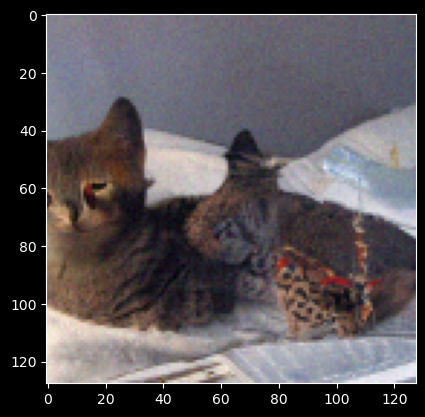

In [19]:
plt.imshow(to_image(res))

# Euler

In [20]:
generator = torch.Generator().manual_seed(0)
res = torch.randn([1, 3, 128, 128], generator=generator).cuda()

num_steps = 1000
betas = np.linspace(0.001, 0.999, num_steps)[::-1]


def F(x, beta):
    coeff = 1 / (1 - beta)
    with torch.no_grad():
        e = call_model(model, x, beta)

    return 0.5 * (x - e / beta**0.5) * coeff


for beta in betas[:-1]:
    dt = 0.999 / (num_steps - 1)
    res = res + F(res, beta) * dt

tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-0.993, 0.836] μ=-0.237 σ=0.376 cuda:0


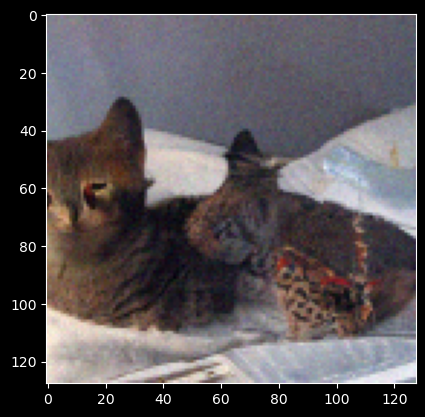

In [21]:
print(lt.lovely(res))
plt.imshow(to_image(res))

# Heun's Solver

In [22]:
generator = torch.Generator().manual_seed(0)
res = torch.randn([1, 3, 128, 128], generator=generator).cuda()

num_steps = 1000
betas = np.linspace(0.001, 0.999, num_steps)[::-1]

for beta in betas[:-1]:
    dt = 0.998 / (num_steps - 1)

    k1 = F(res, beta)
    if step != 0:
        k2 = F(res + k1 * dt, beta - dt)
    else:
        k2 = k1

    res = res + (k1 + k2) * dt / 2

tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-0.978, 0.820] μ=-0.218 σ=0.368 cuda:0


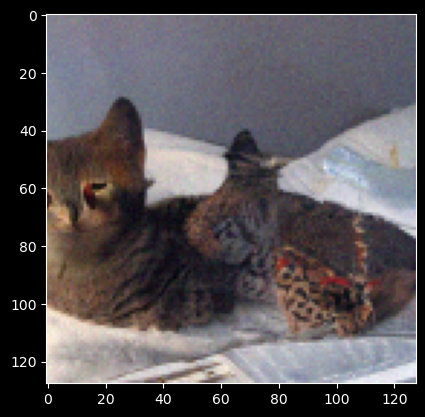

In [23]:
print(lt.lovely(res))
plt.imshow(to_image(res))

Для лучшего качества необходимо вместо linspace применять расписание, которое в начале и конце имеет более мелкий шаг, а в середине разгоняется, например, косинусное распределение. Минимальное значение beta нужно взять меньше. Также нужно будет значение dt умножать на производную функции, генерирующей расписание.

In [47]:
import numpy as np
from sympy import sech
import torch


def sigmoidspace(low, high, n, shape=1):
    raw = np.tanh(np.linspace(-shape, shape, n))
    return (raw - raw[0]) / (raw[-1] - raw[0]) * (high - low) + low


def sigmoidspace_derivative(low, high, n, shape=1):
    raw = np.tanh(np.linspace(-shape, shape, n))
    scaled = (raw - raw[0]) / (raw[-1] - raw[0]) * (high - low) + low
    derivative = np.gradient(scaled, np.linspace(low, high, n))
    return derivative


# Example usage
low = 0.001
high = 0.999
n = 1000
shape = 2

derivative = sigmoidspace_derivative(low, high, n, shape)

generator = torch.Generator().manual_seed(0)
res = torch.randn([1, 3, 128, 128], generator=generator).cuda()

num_steps = 1000
betas = sigmoidspace(0.0001, 0.999, num_steps, shape)[::-1]


def F(x, beta):
    coeff = 1 / (1 - beta)
    with torch.no_grad():
        e = call_model(model, x, beta)

    return 0.5 * (x - e / beta**0.5) * coeff


for beta, der in zip(betas[:-1], derivative[:-1]):
    dt = 0.999 / (num_steps - 1)
    res = res + F(res, beta) * dt * der

tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-0.952, 0.808] μ=-0.216 σ=0.366 cuda:0


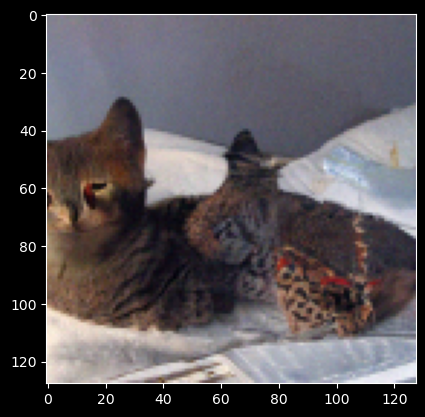

In [48]:
print(lt.lovely(res))
plt.imshow(to_image(res))

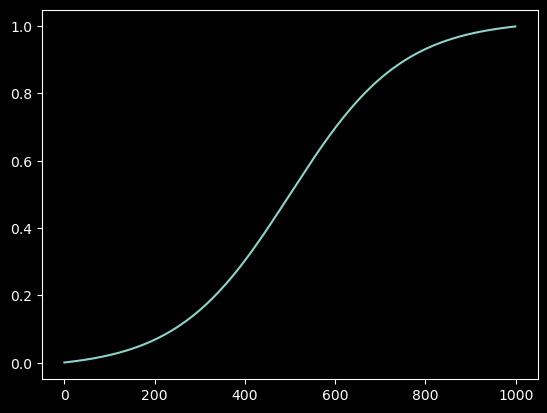

In [46]:
plt.plot(sigmoidspace(low, high, n, shape=2))